# CNN for AED with Keras/TensorFlow (restaurant)

Date: Nov 19, 2018

Speech recognition with Keras/TensorFlow

Data acquisition: living room

Feature set: MFCCs

## Preparing data set for CNN

In [1]:
DATA_FOLDER = '../oscilloscope/data_restaurant/'

FILTERS=40
FILES = 30
TRAINING_FILES = 20
TEST_FILES = FILES - TRAINING_FILES

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import random
import os
import sklearn.preprocessing as pp

In [3]:
import glob

data_files = glob.glob(DATA_FOLDER+'*mfcc*.csv')
class_labels = []

for file in data_files:
    label = file.split('-')[0].replace('\\', '/').split('/')[-1]
    if label not in class_labels:
        class_labels.append(label)

data_set = {}

class_number = 0

for label in class_labels:
    files = glob.glob(DATA_FOLDER+'{}-*mfcc*.csv'.format(label))
    random.shuffle(files)
    data_set[label] = (files[:TRAINING_FILES], files[TRAINING_FILES:FILES], class_number)
    class_number += 1

training_set = []
test_set = []

LENGTH=96

for k, v in data_set.items():
    files = v[0]
    class_number = v[2]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            img1 = pp.scale(data[:FILTERS*LENGTH])
            training_set.append((img1, class_number))
    files = v[1]
    for file in files:
        with open(file) as f:
            data = np.array(f.read().split(',')).astype(float)
            img1 = pp.scale(data[:FILTERS*LENGTH])
            test_set.append((img1, class_number))

random.shuffle(training_set)
random.shuffle(test_set)

class_labels = [None for _ in range(len(data_set))]

# Class number and class labels
for k,v in data_set.items():
    print('{}: {}'.format(v[2],k ))
    class_labels[v[2]] = k

import yaml
with open(DATA_FOLDER+'class_labels.yaml', 'w') as f:
    yaml.dump(class_labels, f)

len(training_set), class_labels

0: mazui
1: oishii
2: others
3: umai


(80, ['mazui', 'oishii', 'others', 'umai'])

C:\Users\shiny\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


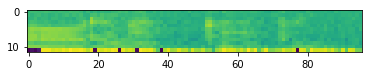

In [4]:
train_data, train_labels = [], []
test_data, test_labels = [], []
for img, label in training_set:
    train_data.append(img)
    train_labels.append(label)
for img, label in test_set:
    test_data.append(img)
    test_labels.append(label)
train_data = np.array(train_data, dtype='float32').reshape((TRAINING_FILES*len(class_labels), LENGTH, FILTERS, 1))
train_data = train_data[:,:,:12,:]

train_labels = np.array(train_labels, dtype='uint8')
test_data = np.array(test_data, dtype='float32').reshape((TEST_FILES*len(class_labels), LENGTH, FILTERS, 1))
test_data = test_data[:,:,:12,:]

test_lables = np.array(test_labels, dtype='uint8')
#train_data.shape

from keras.utils import to_categorical

train_labels=to_categorical(train_labels)
test_labels=to_categorical(test_labels)

plt.imshow(np.rot90(train_data[20 ,:,:,0]))

### CNN model

In [5]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(LENGTH, 12, 1)))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,1)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 10, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 47, 10, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 8, 16)         1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 8, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 6, 32)         4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 6, 32)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 4, 64)          18496     
__________

In [6]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

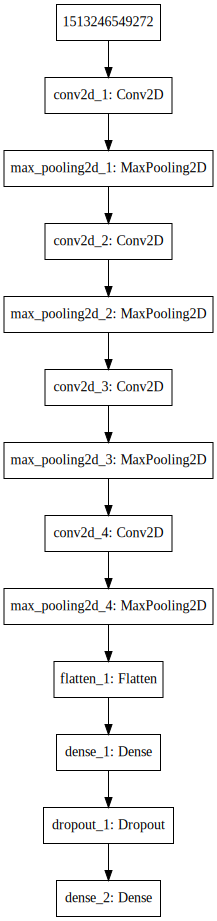

In [7]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [8]:
EPOCHS = 30
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels), batch_size=10)

Train on 80 samples, validate on 40 samples
Epoch 1/30
80/80 [==============================] - 8s 96ms/step - loss: 1.3996 - acc: 0.2875 - val_loss: 1.2960 - val_acc: 0.4750
Epoch 2/30
80/80 [==============================] - 4s 56ms/step - loss: 1.2795 - acc: 0.4250 - val_loss: 1.1230 - val_acc: 0.5500
Epoch 3/30
80/80 [==============================] - 5s 58ms/step - loss: 1.2269 - acc: 0.4750 - val_loss: 0.9817 - val_acc: 0.6750
Epoch 4/30
80/80 [==============================] - 4s 54ms/step - loss: 0.9126 - acc: 0.6750 - val_loss: 0.8194 - val_acc: 0.7250
Epoch 5/30
80/80 [==============================] - 5s 57ms/step - loss: 0.8455 - acc: 0.7250 - val_loss: 0.8256 - val_acc: 0.7000
Epoch 6/30
80/80 [==============================] - 4s 52ms/step - loss: 0.8181 - acc: 0.7125 - val_loss: 0.6038 - val_acc: 0.8000
Epoch 7/30
80/80 [==============================] - 4s 52ms/step - loss: 0.5686 - acc: 0.7750 - val_loss: 0.4966 - val_acc: 0.8500
Epoch 8/30
80/80 [=====================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


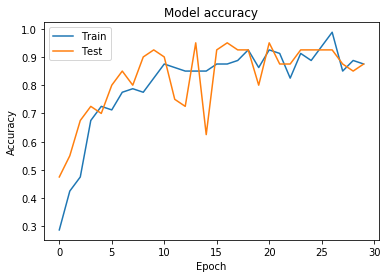

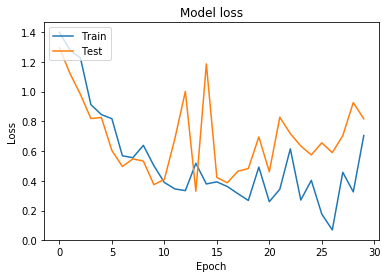

In [9]:
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Save the model

In [10]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = 'cnn_for_aed_restaurant_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [11]:
del model
model = models.load_model(filename)

## Confirmation

In [12]:
import numpy as np
import matplotlib.pyplot as plt
train_data.shape

(80, 96, 12, 1)

In [13]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [14]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [15]:
class_labels

['mazui', 'oishii', 'others', 'umai']

In [16]:
(activations[-1][:10]*100).astype(int)

array([[  0,   0,  82,  17],
       [  0,   0,  33,  66],
       [ 99,   0,   0,   0],
       [  0,   0,   1,  98],
       [  0,  99,   0,   0],
       [  0,   0,   0,  99],
       [  0,   0,   0,  99],
       [  0,   0,   0, 100],
       [  0,  99,   0,   0],
       [ 99,   0,   0,   0]])

In [17]:
test_labels[:10].astype(int)

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [1, 0, 0, 0]])

In [18]:
def plot_layer(activations, sample, layer):
    a = activations[layer].shape
    rows = int(a[3]/4)
    fig, axarr = plt.subplots(rows, 4, figsize=[20,15])
    for i in range(a[3]):
        row = int(i/4)
        x, y = row, i-4*row
        axarr[x, y].imshow(np.rot90(activations[layer][sample, :, :, i]))
        axarr[x, y].set_xticks([])
        axarr[x, y].set_yticks([])

'oishii'

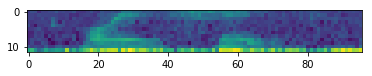

In [19]:
image_number = 8

plt.imshow(np.rot90(test_data[image_number,:,:,0]))
class_labels[np.argmax(test_labels[image_number])]

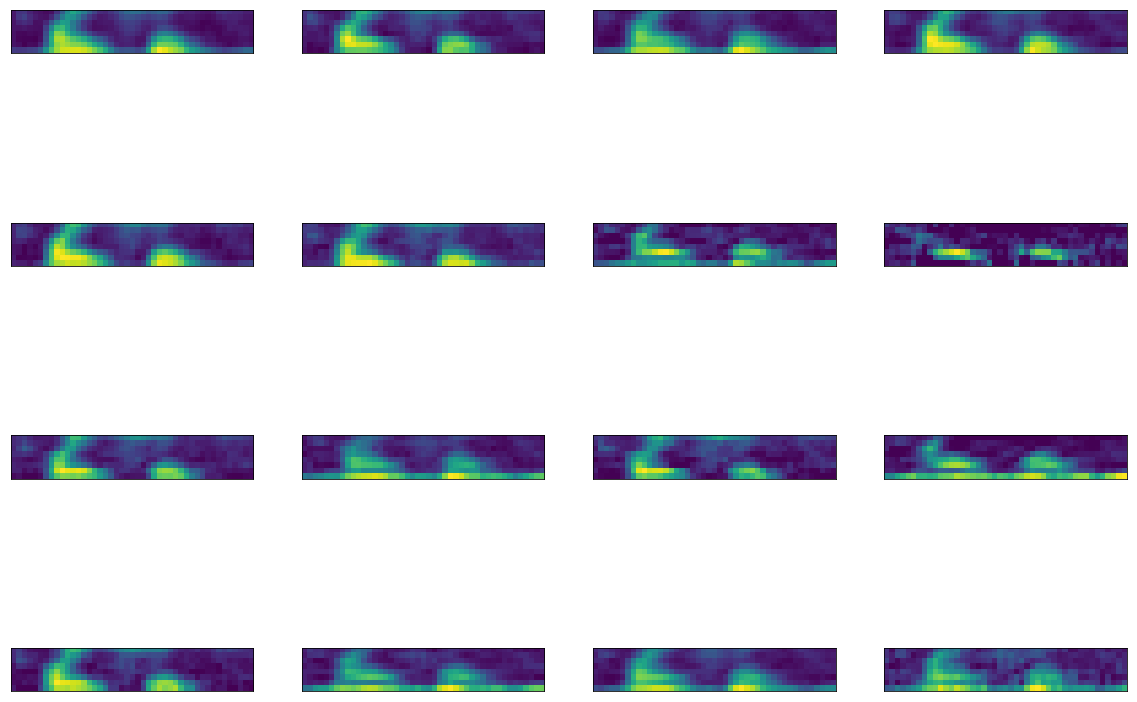

In [20]:
plot_layer(activations, image_number, 2)

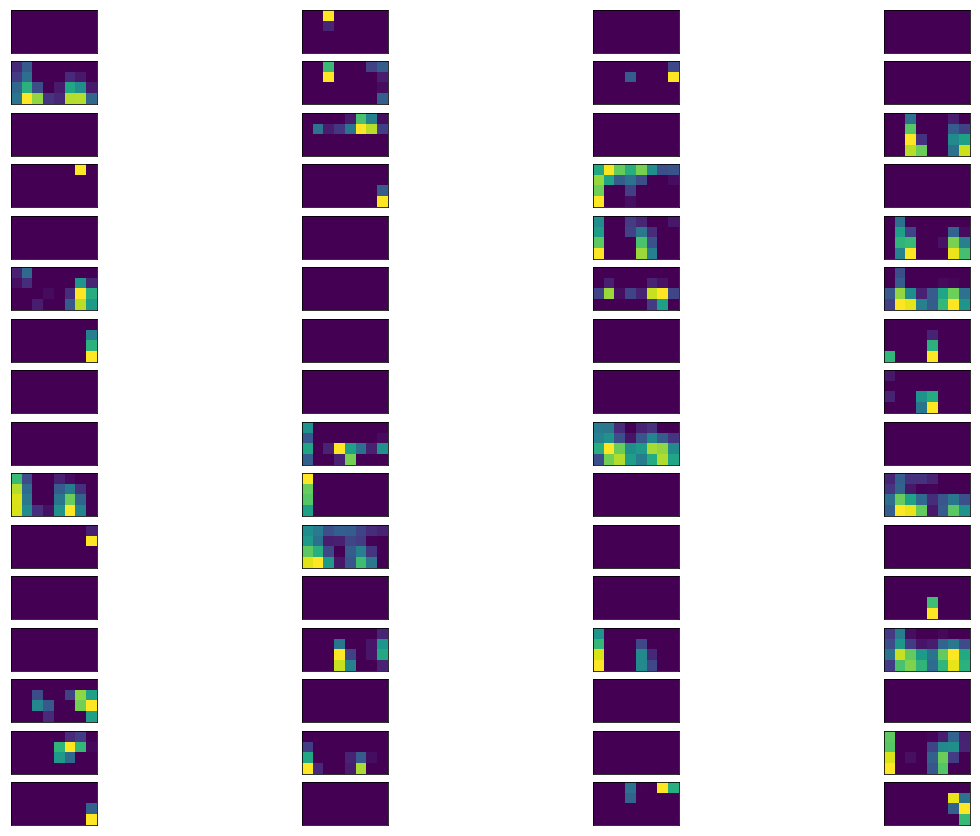

In [21]:
plot_layer(activations, image_number, 6)